In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### 패키지 설치 & 라이브러리 import

In [ ]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성




In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [ ]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(tri)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back=sequence_length)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

In [ ]:
# 데이터셋 출력
# raw

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


#### 3. 나뉜된 데이터셋 구조 확인

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # splited 데이터 경로 시각화 함수
# def plot_trajectory(train_data, val_data, test_data):
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')

#     # 훈련 데이터 플롯
#     ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

#     # 검증 데이터 플롯
#     ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

#     # 테스트 데이터 플롯
#     ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

#     # 그래프 레이블
#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Longitude')
#     ax.set_zlabel('Altitude')

#     # 제목과 범례
#     ax.set_title('Drone Trajectory: Train, Validation, and Test')
#     ax.legend()

#     plt.show()


In [ ]:
# # ############## 예시: 함수 사용
train_data, val_data, test_data = split_train_val_test(tri)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# plot_trajectory(train_data, val_data, test_data)

# X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=10)
# print(X_train[0])
# print(y_train[0])

# # ######################

(3256, 4)
(1086, 4)
(1086, 4)


## 모델 선언

### 1. 모델 클래스 선언

- LSTM을 사용한 모델 클래스 선언
- 구조 : LSTM + Fully Connected Layer

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna

# LSTM 모델 클래스 정의
class LSTM_Model(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, output_size=3):
        super(LSTM_Model, self).__init__()

        # hidden state size
        self.hidden_size = hidden_size

        # LSTM layer 수
        self.num_layers = num_layers

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):


        # LSTM hidden state, cell state 초기화
        # 초기 hidden state와 cell state 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 레이어를 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시점의 hidden state에서 Fully Connected Layer를 통과
        out = self.fc(out[:, -1, :])

        return out

## 하이퍼파라미터 탐색

### 1. Optuna의 objective 함수 선언

- 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
- objective 함수 선언

In [ ]:
import optuna
import torch

def objective(trial, tri, sequence_length):
    # 탐색할 하이퍼파라미터 값 결정
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    num_epochs = 300
    input_size = 3  # lat, lon, alt
    output_size = 3  # lat, lon, alt

    # 데이터셋 가져오기
    train_loader, val_loader, _ = create_dataloaders(tri, batch_size, sequence_length)

    # 모델 정의: LSTMModel
    model = LSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    total_val_loss = 0.0  # 모든 epoch에서의 validation loss의 합
    val_loss_count = 0    # 평균을 계산하기 위한 epoch 수

    # 모델 학습
    for epoch in range(num_epochs):

        # Train set으로 학습
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation set에서 성능 측정
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        # 배치 수로 나눠서 평균 validation 손실 계산
        val_loss_avg = val_loss / len(val_loader)

        # Optuna에 중간 값 보고
        trial.report(val_loss_avg, epoch)

        # 총 validation 손실 계산
        total_val_loss += val_loss_avg
        val_loss_count += 1

        # Pruning 조건 확인
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            print(f"Validation Loss at prune: {val_loss_avg:.4f}")  # Prune 시점에서 validation loss 출력

            raise optuna.TrialPruned()

    # 모든 epoch에서의 validation 손실 평균을 반환
    return total_val_loss / val_loss_count

### 2. early stopping 함수 선언

- optuna에서 하이퍼파라미터 탐색 중 early stopping 적용

In [ ]:
#  # https://github.com/optuna/optuna/issues/1001

# def early_stopping_check(study, trial, early_stopping_rounds=10):
#   current_trial_number = trial.number
#   best_trial_number = study.best_trial.number
#   should_stop = (current_trial_number - best_trial_number) >= early_stopping_rounds
#   if should_stop:
#       print(f"Early stopping detected: stopping trial {current_trial_number} (best trial {best_trial_number}) at epoch {epoch}")
#       study.stop()

### 3. 탐색 범위 외의 하이퍼파라미터 선언

In [ ]:
sequence_length = 10
early_stopping_rounds = 10
n_trials = 100

### 4. 하이퍼 파라미터 탐색

In [ ]:
import optuna
from functools import partial

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-07 14:12:24,637] A new study created in memory with name: no-name-3a5911da-c6d4-4fcb-b3d8-eaec983ef879
[I 2024-10-07 14:13:39,851] Trial 0 finished with value: 0.002011951477178138 and parameters: {'hidden_size': 234, 'num_layers': 3, 'learning_rate': 0.006506994355818873, 'batch_size': 87}. Best is trial 0 with value: 0.002011951477178138.
[I 2024-10-07 14:14:40,068] Trial 1 finished with value: 0.0003342654946382702 and parameters: {'hidden_size': 111, 'num_layers': 2, 'learning_rate': 0.0015187196505828421, 'batch_size': 62}. Best is trial 1 with value: 0.0003342654946382702.
[I 2024-10-07 14:18:22,094] Trial 2 finished with value: 0.0011907964825491719 and parameters: {'hidden_size': 67, 'num_layers': 3, 'learning_rate': 9.480875649418714e-05, 'batch_size': 16}. Best is trial 1 with value: 0.0003342654946382702.
[I 2024-10-07 14:19:02,382] Trial 3 finished with value: 0.0015742312819778225 and parameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.001294002

Trial 5 pruned at epoch 23
Validation Loss at prune: 0.0009


[I 2024-10-07 14:20:02,506] Trial 6 pruned. 


Trial 6 pruned at epoch 10
Validation Loss at prune: 0.0049


[I 2024-10-07 14:20:04,606] Trial 7 pruned. 


Trial 7 pruned at epoch 10
Validation Loss at prune: 0.0041


[I 2024-10-07 14:20:05,857] Trial 8 pruned. 


Trial 8 pruned at epoch 10
Validation Loss at prune: 0.2486


[I 2024-10-07 14:20:07,841] Trial 9 pruned. 


Trial 9 pruned at epoch 10
Validation Loss at prune: 0.0179


[I 2024-10-07 14:20:11,751] Trial 10 pruned. 


Trial 10 pruned at epoch 10
Validation Loss at prune: 0.0067


[I 2024-10-07 14:20:58,846] Trial 11 finished with value: 0.0004497510583203807 and parameters: {'hidden_size': 114, 'num_layers': 2, 'learning_rate': 0.0019913771083375493, 'batch_size': 83}. Best is trial 1 with value: 0.0003342654946382702.
[I 2024-10-07 14:22:12,067] Trial 12 finished with value: 0.00016058781905409596 and parameters: {'hidden_size': 120, 'num_layers': 2, 'learning_rate': 0.0024457195731404026, 'batch_size': 48}. Best is trial 12 with value: 0.00016058781905409596.
[I 2024-10-07 14:23:26,746] Trial 13 finished with value: 0.000161322251444092 and parameters: {'hidden_size': 193, 'num_layers': 1, 'learning_rate': 0.0030332302613316374, 'batch_size': 43}. Best is trial 12 with value: 0.00016058781905409596.
[I 2024-10-07 14:24:44,135] Trial 14 finished with value: 0.00011226621067089306 and parameters: {'hidden_size': 197, 'num_layers': 1, 'learning_rate': 0.004397445379902527, 'batch_size': 41}. Best is trial 14 with value: 0.00011226621067089306.
[I 2024-10-07 14:2

Trial 16 pruned at epoch 10
Validation Loss at prune: 0.0009


[I 2024-10-07 14:26:29,280] Trial 17 pruned. 


Trial 17 pruned at epoch 10
Validation Loss at prune: 0.0072


[I 2024-10-07 14:26:33,821] Trial 18 pruned. 


Trial 18 pruned at epoch 10
Validation Loss at prune: 0.0014


[I 2024-10-07 14:26:46,041] Trial 19 pruned. 


Trial 19 pruned at epoch 10
Validation Loss at prune: 0.0068


[I 2024-10-07 14:26:48,187] Trial 20 pruned. 


Trial 20 pruned at epoch 10
Validation Loss at prune: 0.0015


[I 2024-10-07 14:28:12,504] Trial 21 finished with value: 0.00021213019598141482 and parameters: {'hidden_size': 136, 'num_layers': 2, 'learning_rate': 0.003291675139180441, 'batch_size': 48}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:29:23,528] Trial 22 finished with value: 9.75335299620751e-05 and parameters: {'hidden_size': 148, 'num_layers': 1, 'learning_rate': 0.00869740119156138, 'batch_size': 47}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:30:46,547] Trial 23 finished with value: 0.00010826822420131318 and parameters: {'hidden_size': 198, 'num_layers': 1, 'learning_rate': 0.008942989197429802, 'batch_size': 38}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:31:49,230] Trial 24 finished with value: 0.00014659360978383048 and parameters: {'hidden_size': 161, 'num_layers': 1, 'learning_rate': 0.008469829978712396, 'batch_size': 55}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:33:41,

Trial 26 pruned at epoch 11
Validation Loss at prune: 0.0002


[I 2024-10-07 14:33:51,028] Trial 27 pruned. 


Trial 27 pruned at epoch 10
Validation Loss at prune: 0.0068


[I 2024-10-07 14:33:54,093] Trial 28 pruned. 


Trial 28 pruned at epoch 11
Validation Loss at prune: 0.0004


[I 2024-10-07 14:34:17,215] Trial 29 pruned. 


Trial 29 pruned at epoch 31
Validation Loss at prune: 0.0006


[I 2024-10-07 14:34:20,536] Trial 30 pruned. 


Trial 30 pruned at epoch 10
Validation Loss at prune: 0.0005


[I 2024-10-07 14:35:38,121] Trial 31 finished with value: 7.400861990721927e-05 and parameters: {'hidden_size': 198, 'num_layers': 1, 'learning_rate': 0.004055713525488126, 'batch_size': 41}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:35:40,285] Trial 32 pruned. 


Trial 32 pruned at epoch 10
Validation Loss at prune: 0.0006


[I 2024-10-07 14:35:43,266] Trial 33 pruned. 


Trial 33 pruned at epoch 10
Validation Loss at prune: 0.0007


[I 2024-10-07 14:35:47,360] Trial 34 pruned. 


Trial 34 pruned at epoch 10
Validation Loss at prune: 0.0025


[I 2024-10-07 14:36:50,054] Trial 35 pruned. 


Trial 35 pruned at epoch 86
Validation Loss at prune: 0.0000


[I 2024-10-07 14:36:53,100] Trial 36 pruned. 


Trial 36 pruned at epoch 11
Validation Loss at prune: 0.0010


[I 2024-10-07 14:37:41,288] Trial 37 finished with value: 0.00012411790586323453 and parameters: {'hidden_size': 221, 'num_layers': 1, 'learning_rate': 0.004006625715924062, 'batch_size': 73}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:37:44,663] Trial 38 pruned. 


Trial 38 pruned at epoch 11
Validation Loss at prune: 0.0003


[I 2024-10-07 14:38:44,528] Trial 39 finished with value: 8.246112883571137e-05 and parameters: {'hidden_size': 189, 'num_layers': 1, 'learning_rate': 0.006922834381156409, 'batch_size': 67}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:38:46,613] Trial 40 pruned. 


Trial 40 pruned at epoch 10
Validation Loss at prune: 0.0018


[I 2024-10-07 14:39:46,243] Trial 41 finished with value: 9.776727990730945e-05 and parameters: {'hidden_size': 186, 'num_layers': 1, 'learning_rate': 0.00764329767496057, 'batch_size': 66}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:40:45,129] Trial 42 finished with value: 7.12446510795407e-05 and parameters: {'hidden_size': 185, 'num_layers': 1, 'learning_rate': 0.006786043087986728, 'batch_size': 67}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:40:48,559] Trial 43 pruned. 


Trial 43 pruned at epoch 15
Validation Loss at prune: 0.0002


[I 2024-10-07 14:40:50,949] Trial 44 pruned. 


Trial 44 pruned at epoch 10
Validation Loss at prune: 0.0009


[I 2024-10-07 14:40:53,381] Trial 45 pruned. 


Trial 45 pruned at epoch 10
Validation Loss at prune: 0.0740


[I 2024-10-07 14:40:55,432] Trial 46 pruned. 


Trial 46 pruned at epoch 10
Validation Loss at prune: 0.0003


[I 2024-10-07 14:40:57,437] Trial 47 pruned. 


Trial 47 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 14:40:59,347] Trial 48 pruned. 


Trial 48 pruned at epoch 10
Validation Loss at prune: 0.0006


[I 2024-10-07 14:42:20,418] Trial 49 finished with value: 9.945683923535934e-05 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0018655860709912684, 'batch_size': 43}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:43:12,900] Trial 50 finished with value: 0.0001052200072101208 and parameters: {'hidden_size': 169, 'num_layers': 1, 'learning_rate': 0.007129679585007234, 'batch_size': 78}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:43:15,224] Trial 51 pruned. 


Trial 51 pruned at epoch 10
Validation Loss at prune: 0.0009


[I 2024-10-07 14:43:17,976] Trial 52 pruned. 


Trial 52 pruned at epoch 10
Validation Loss at prune: 0.0007


[I 2024-10-07 14:43:20,246] Trial 53 pruned. 


Trial 53 pruned at epoch 10
Validation Loss at prune: 0.0003


[I 2024-10-07 14:44:13,355] Trial 54 finished with value: 9.205456289449986e-05 and parameters: {'hidden_size': 183, 'num_layers': 1, 'learning_rate': 0.006759136157301238, 'batch_size': 88}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:44:15,021] Trial 55 pruned. 


Trial 55 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 14:44:18,323] Trial 56 pruned. 


Trial 56 pruned at epoch 10
Validation Loss at prune: 0.0003


[I 2024-10-07 14:44:20,754] Trial 57 pruned. 


Trial 57 pruned at epoch 10
Validation Loss at prune: 0.0006


[I 2024-10-07 14:44:23,892] Trial 58 pruned. 


Trial 58 pruned at epoch 10
Validation Loss at prune: 0.0060


[I 2024-10-07 14:45:32,364] Trial 59 finished with value: 0.00018736863326183467 and parameters: {'hidden_size': 193, 'num_layers': 1, 'learning_rate': 0.007137648670642379, 'batch_size': 47}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:47:22,364] Trial 60 finished with value: 8.447808955314908e-05 and parameters: {'hidden_size': 168, 'num_layers': 1, 'learning_rate': 0.0038198150415474853, 'batch_size': 27}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:49:12,435] Trial 61 finished with value: 6.599227731714066e-05 and parameters: {'hidden_size': 166, 'num_layers': 1, 'learning_rate': 0.005374141954499434, 'batch_size': 27}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:50:53,230] Trial 62 finished with value: 8.993221808268523e-05 and parameters: {'hidden_size': 165, 'num_layers': 1, 'learning_rate': 0.003715359572583444, 'batch_size': 30}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:52:46

Trial 64 pruned at epoch 11
Validation Loss at prune: 0.0003


[I 2024-10-07 14:55:13,830] Trial 65 finished with value: 8.857683819443267e-05 and parameters: {'hidden_size': 164, 'num_layers': 1, 'learning_rate': 0.00215775503569257, 'batch_size': 20}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:55:26,666] Trial 66 pruned. 


Trial 66 pruned at epoch 10
Validation Loss at prune: 0.0138


[I 2024-10-07 14:55:29,599] Trial 67 pruned. 


Trial 67 pruned at epoch 10
Validation Loss at prune: 0.0010


[I 2024-10-07 14:55:34,037] Trial 68 pruned. 


Trial 68 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 14:57:33,001] Trial 69 finished with value: 8.652306210977529e-05 and parameters: {'hidden_size': 189, 'num_layers': 1, 'learning_rate': 0.003836711866465102, 'batch_size': 25}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 14:59:14,448] Trial 70 finished with value: 8.283252138817766e-05 and parameters: {'hidden_size': 198, 'num_layers': 1, 'learning_rate': 0.0016994182722981019, 'batch_size': 30}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:01:01,443] Trial 71 finished with value: 9.22854874092175e-05 and parameters: {'hidden_size': 180, 'num_layers': 1, 'learning_rate': 0.005013171973819276, 'batch_size': 28}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:01:06,090] Trial 72 pruned. 


Trial 72 pruned at epoch 12
Validation Loss at prune: 0.0002


[I 2024-10-07 15:01:11,663] Trial 73 pruned. 


Trial 73 pruned at epoch 12
Validation Loss at prune: 0.0002


[I 2024-10-07 15:01:15,899] Trial 74 pruned. 


Trial 74 pruned at epoch 12
Validation Loss at prune: 0.0001


[I 2024-10-07 15:03:52,805] Trial 75 finished with value: 6.914791948237409e-05 and parameters: {'hidden_size': 174, 'num_layers': 1, 'learning_rate': 0.0011254126270606247, 'batch_size': 18}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:06:23,014] Trial 76 finished with value: 7.116235990106919e-05 and parameters: {'hidden_size': 192, 'num_layers': 1, 'learning_rate': 0.0011788968955215606, 'batch_size': 19}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:06:32,290] Trial 77 pruned. 


Trial 77 pruned at epoch 12
Validation Loss at prune: 0.0001


[I 2024-10-07 15:06:37,824] Trial 78 pruned. 


Trial 78 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 15:06:44,708] Trial 79 pruned. 


Trial 79 pruned at epoch 10
Validation Loss at prune: 0.0007


[I 2024-10-07 15:06:47,950] Trial 80 pruned. 


Trial 80 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 15:06:51,748] Trial 81 pruned. 


Trial 81 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-07 15:06:57,100] Trial 82 pruned. 


Trial 82 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-07 15:07:00,710] Trial 83 pruned. 


Trial 83 pruned at epoch 10
Validation Loss at prune: 0.0006


[I 2024-10-07 15:09:56,373] Trial 84 finished with value: 7.941989158106652e-05 and parameters: {'hidden_size': 184, 'num_layers': 1, 'learning_rate': 0.0018580138210635608, 'batch_size': 16}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:12:51,134] Trial 85 finished with value: 9.784486140872851e-05 and parameters: {'hidden_size': 161, 'num_layers': 1, 'learning_rate': 0.002300144904296931, 'batch_size': 16}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:12:57,030] Trial 86 pruned. 


Trial 86 pruned at epoch 11
Validation Loss at prune: 0.0004


[I 2024-10-07 15:14:47,412] Trial 87 finished with value: 0.0004470869601895494 and parameters: {'hidden_size': 57, 'num_layers': 1, 'learning_rate': 0.005662989009931844, 'batch_size': 24}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:14:58,112] Trial 88 pruned. 


Trial 88 pruned at epoch 10
Validation Loss at prune: 0.0011


[I 2024-10-07 15:17:51,277] Trial 89 finished with value: 0.00013171849518523493 and parameters: {'hidden_size': 153, 'num_layers': 1, 'learning_rate': 0.00205643659105545, 'batch_size': 16}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:17:55,248] Trial 90 pruned. 


Trial 90 pruned at epoch 10
Validation Loss at prune: 0.0046


[I 2024-10-07 15:19:23,751] Trial 91 finished with value: 8.849530668946439e-05 and parameters: {'hidden_size': 202, 'num_layers': 1, 'learning_rate': 0.0016071228429970516, 'batch_size': 35}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:21:41,176] Trial 92 finished with value: 8.789519869646381e-05 and parameters: {'hidden_size': 189, 'num_layers': 1, 'learning_rate': 0.0011628627799476193, 'batch_size': 21}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:21:43,214] Trial 93 pruned. 


Trial 93 pruned at epoch 10
Validation Loss at prune: 0.0007


[I 2024-10-07 15:23:39,199] Trial 94 finished with value: 7.033291984656544e-05 and parameters: {'hidden_size': 197, 'num_layers': 1, 'learning_rate': 0.0017457829994533963, 'batch_size': 26}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:23:43,384] Trial 95 pruned. 


Trial 95 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-07 15:23:48,024] Trial 96 pruned. 


Trial 96 pruned at epoch 10
Validation Loss at prune: 0.0008


[I 2024-10-07 15:25:12,570] Trial 97 finished with value: 8.702470780738765e-05 and parameters: {'hidden_size': 192, 'num_layers': 1, 'learning_rate': 0.0032937117833392775, 'batch_size': 38}. Best is trial 15 with value: 6.583269049682751e-05.
[I 2024-10-07 15:25:14,776] Trial 98 pruned. 


Trial 98 pruned at epoch 10
Validation Loss at prune: 0.0009


[I 2024-10-07 15:25:21,218] Trial 99 pruned. 


Trial 99 pruned at epoch 10
Validation Loss at prune: 0.0002
Best hyperparameters:  {'hidden_size': 213, 'num_layers': 1, 'learning_rate': 0.004672420526588498, 'batch_size': 33}


### 5. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [ ]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'hidden_size': 213, 'num_layers': 1, 'learning_rate': 0.004672420526588498, 'batch_size': 33}


### 2. 최적의 파라미터로 모델 학습

In [ ]:
sequence_length = 10
num_epochs = 300

In [ ]:
# 최적의 모델 학습

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = LSTM_Model(input_size=3, hidden_size=best_params['hidden_size'],
                      num_layers=best_params['num_layers'], output_size=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

In [ ]:
import time
import torch

# 학습 및 검증 손실을 기록할 리스트
train_losses = []
val_losses = []

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # 평균 손실 계산 및 저장
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 100 == 0:
      model_save_path = f"best_model_epoch_{epoch+1}.pth"
      torch.save(best_model, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/300], Train Loss: 2.9184, Val Loss: 0.1876
Epoch 1/300 completed in 0.29 seconds.
Epoch [2/300], Train Loss: 0.1315, Val Loss: 0.0327
Epoch 2/300 completed in 0.28 seconds.
Epoch [3/300], Train Loss: 0.0264, Val Loss: 0.0192
Epoch 3/300 completed in 0.28 seconds.
Epoch [4/300], Train Loss: 0.0233, Val Loss: 0.0170
Epoch 4/300 completed in 0.27 seconds.
Epoch [5/300], Train Loss: 0.0226, Val Loss: 0.0158
Epoch 5/300 completed in 0.28 seconds.
Epoch [6/300], Train Loss: 0.0234, Val Loss: 0.0082
Epoch 6/300 completed in 0.27 seconds.
Epoch [7/300], Train Loss: 0.0150, Val Loss: 0.0168
Epoch 7/300 completed in 0.27 seconds.
Epoch [8/300], Train Loss: 0.0131, Val Loss: 0.0034
Epoch 8/300 completed in 0.27 seconds.
Epoch [9/300], Train Loss: 0.0112, Val Loss: 0.0059
Epoch 9/300 completed in 0.27 seconds.
Epoch [10/300], Train Loss: 0.0085, Val Loss: 0.0034
Epoch 10/300 completed in 0.26 seconds.
Epoch [11/300], Train Loss: 0.0088, Val Loss: 0.0041
Epoch 11/300 completed in 0.27 seco

### 3. loss 그래프 출력

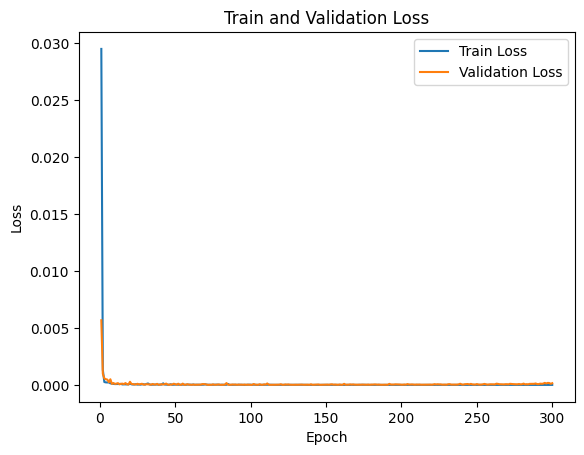

In [ ]:
# 손실 그래프 출력
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

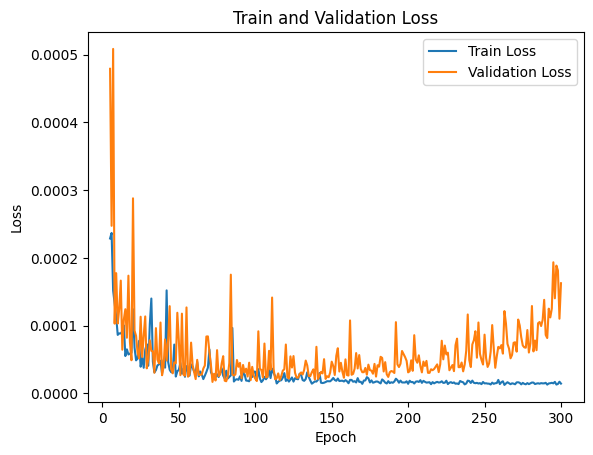

In [ ]:
# 손실 그래프 출력
plt.plot(range(5, num_epochs + 1), train_losses[4:], label='Train Loss')
plt.plot(range(5, num_epochs + 1), val_losses[4:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

### 3. 모델 요약 내용 출력

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               [1, 3]                    --
├─LSTM: 1-1                              [1, 10, 213]              185,736
├─Linear: 1-2                            [1, 3]                    642
Total params: 186,378
Trainable params: 186,378
Non-trainable params: 0
Total mult-adds (M): 1.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.75
Estimated Total Size (MB): 0.76

## 테스트

### 1. 테스트 결과 생성

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 2.3123915525502525e-05
Mean Absolute Error (MAE): 0.0031092260032892227


### 2. 결과 시각화

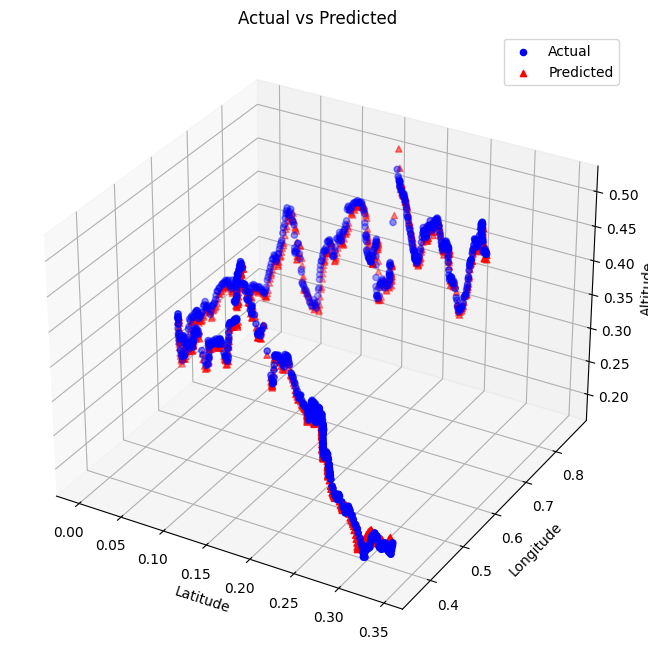

In [ ]:
prediction_visualization(y_true, y_pred)

### 3. raw 데이터와 predict 데이터 비교

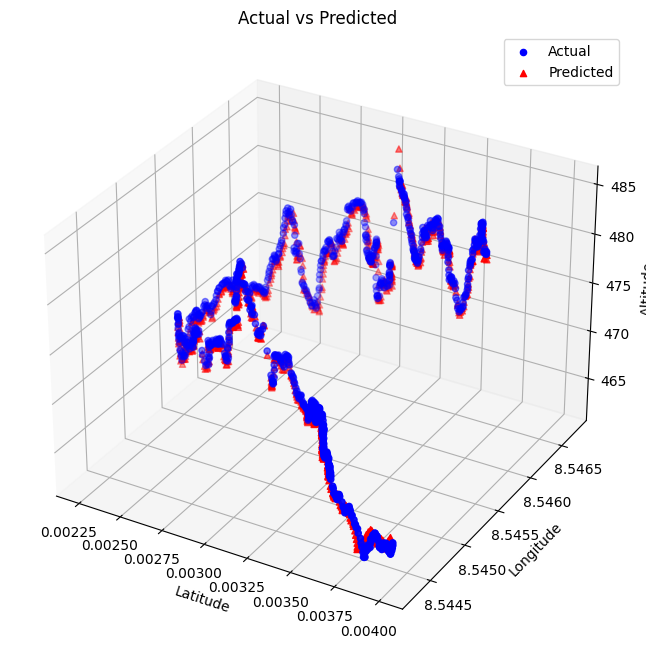

In [ ]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

### 4. 경로 출력 그래프

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def trajectory_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯 (선으로 연결)
    ax.plot(y_test_lat, y_test_lon, y_test_alt, c='b', label='Actual')

    # 예측 값 플롯 (선으로 연결)
    ax.plot(y_pred_lat, y_pred_lon, y_pred_alt, c='r', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

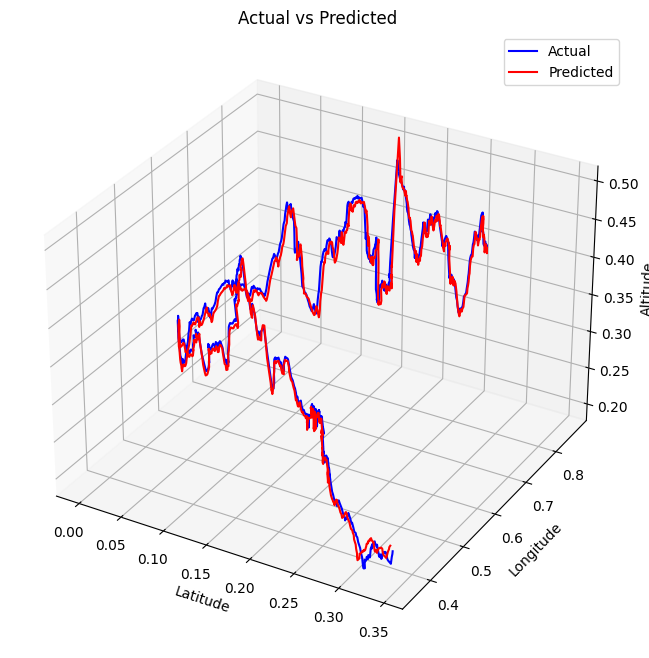

In [ ]:
trajectory_visualization(y_true, y_pred)